In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import random
from scipy.stats import wishart, uniform, gamma, multivariate_normal as mv
from scipy.linalg import det
from scipy.integrate import nquad
from math import pi, e

# this is the package with the joint class 'info' for all information theoretical measures
import nn_info as nit
# this is the collection of information theoretical algorithms based on nearest neighbors with detailed prescription
import estimators as est


random.seed(1234)

# 0. Benchmark

## 0.1. Entropy estimation

### 0.1.1 Gaussian

In [2]:
# Gaussian example for entropy estimation:
#try different dimension via choice of 'd':
d = 1
# sample size
n = 1000
# number of estimates for estimate mean values computation
m = 15

s = 0.5*np.ones(d**2).reshape(-1,d)
I = np.identity(d)
s = s + I

Res=[]
for j in range(50):
    #make Wishart for pos.def. covariance matrice  
    S = wishart.rvs(df=10, scale = s)
    
    res = []
    #compute mean of  KLD estimators (see nnInfo for detailed information)
    for i in range(m):
        X = mv.rvs(np.zeros(d), cov=S, size=n)
        entropy = nit.info('entropy', approach = 'nn_distance', k = 1, unit = 'nats')
        res.append(entropy.estimator(X))
    if d > 1:
        Res.append([np.mean(res), np.std(res), 0.5*np.log(2*e*pi*det(S))])
    else:
        Res.append([np.mean(res), np.std(res), 0.5*(np.log(2*pi*S) + 1)])

F = pd.DataFrame(Res, columns=['estimate', 'std_var', 'truth'])
F.sort_values(by='truth', inplace=True)
F.reset_index(drop=True, inplace=True)

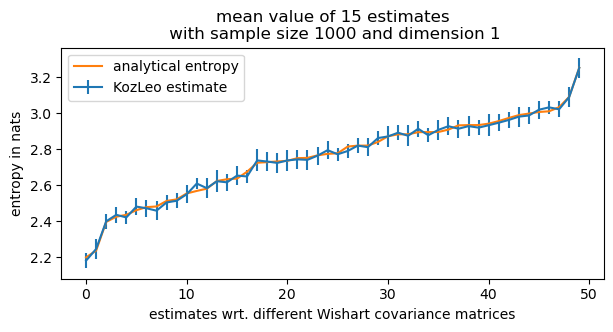

In [3]:
#make plot
fig, ax = plt.subplots(figsize=(7,3))
plt.errorbar(range(len(F)), F.estimate, F.std_var, label='KozLeo estimate')
plt.plot(range(len(F)), F.truth, label='analytical entropy')
plt.xlabel('estimates wrt. different Wishart covariance matrices')
plt.ylabel('entropy in nats')
plt.title('mean value of ' + str(m) + ' estimates\n with sample size ' + str(n) + ' and dimension ' + str(d))
plt.legend()
plt.show()

## 0.2. Kullback-Leibler divergence estimation

### 0.2.1 Gaussian

In [4]:
# Gaussian example with variable covariance matrix, sampled from Wishart distribution
#dimension
d = 3
#center of Gaussian: change center for Gaussian to play with intensity of 0-value inflation
# negative values will be mapped to 0
c = 2.5
# amount of computations for mean value
m = 5
# sample size
n = 1000


s = 0.5*np.ones(d**2).reshape(-1,d)
I = np.identity(d)
s = s + I

E=[]

for j in range(50):
    #make 2 Wisharts for pos.def. covariance matrices  
    S = wishart.rvs(df=10, scale = s, size = 2)
    
    e = []
    #compute mean of 3 KLD estimators (see nnInfo for detailed information)
    for i in range(m):
        X = mv.rvs(c*np.ones(d), cov=S[0], size=n)
        Y = mv.rvs(c*np.ones(d), cov=S[1], size=n)
        e.append((nit.info('KLD', approach='nn_ratio', unit='nats', k=3).estimator((X,Y)),
                  nit.info('KLD', approach='nn_distance', unit='nats', k=4, epsilon=False).estimator((X,Y)), 
                  # the Noshad approach is not part of the class but can be accessed directly
                  est.NMI((X,Y)),
                  nit.KLD_gaussian((X,Y))))
        
    estimates = np.array(e).mean(axis=0)
    #compute true values based on parameter, parameter estimation and 
    #arithmetic mean estimate 
    
    truth = nit.KLD_gaussian(tpl=False, mu0=np.zeros(d), 
                             mu1=np.zeros(d), cov0=S[0], cov1=S[1], samples=False)
    
    E.append(list(estimates) + [truth])
F = pd.DataFrame(E, columns=['BannMI', 'WMI', 'NMI', 'sample estimate', 
                             'truth'])
F.sort_values(by='truth', inplace=True)
F.reset_index(drop=True, inplace=True)

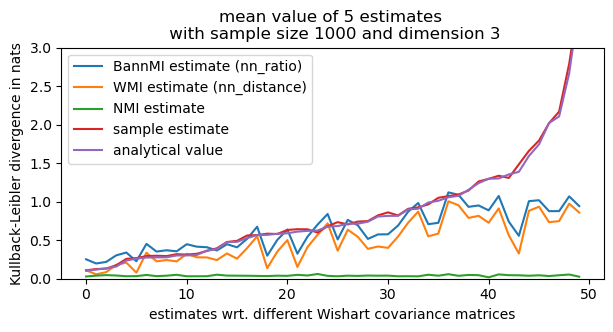

In [5]:
# make plot
fig, ax = plt.subplots(figsize=(7,3))
plt.plot(range(len(F)), F.BannMI, label='BannMI estimate (nn_ratio)')
plt.plot(range(len(F)), F.WMI, label='WMI estimate (nn_distance)')
plt.plot(range(len(F)), F.NMI, label='NMI estimate')
plt.plot(range(len(F)), F.loc[:,['sample estimate']], label='sample estimate')
plt.plot(range(len(F)), F.truth, label='analytical value')
plt.xlabel('estimates wrt. different Wishart covariance matrices')
plt.ylabel('Kullback-Leibler divergence in nats')
plt.title('mean value of ' + str(m) + ' estimates \n with sample size ' + str(n) + ' and dimension ' + str(d))
# some values are very high - therefore restrict y-axis for better visualization
plt.ylim(0,3)
plt.legend()
plt.show()

#### correlation of estimators to analytical value:

In [6]:
# show correlation to analytical value
print(F.iloc[:-5,:].corr().sort_values('truth', ascending=False).iloc[:,-1])

truth              1.000000
sample estimate    0.998262
BannMI             0.834594
WMI                0.796355
NMI                0.153520
Name: truth, dtype: float64


#### data with 0-inflations cause NaN-values for WMI estimator:

In [7]:
# set negative realizations of Gaussian to 0 and thus create 0-inflation as in phosphoproteomic data  
# suppress RuntimeWarning caused by division by zero due to 0-distance in WMI
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


#
Z0 = X.copy()
Z0[Z0<0]=0
Z1 = Y.copy()
Z1[Z1<0]=0

table=pd.DataFrame([[nit.info('KLD', 'nn_ratio', unit='nats').estimator((X,Y)),
                     nit.info('KLD', 'nn_distance', unit='nats').estimator((X,Y))], 
                    [nit.info('KLD', 'nn_ratio', unit='nats').estimator((Z0,Z1)),
                     nit.info('KLD', 'nn_distance', unit='nats').estimator((Z0,Z1))]], 
                   index=['normal', 'with 0-inflation'], columns=['BannMI','WMI'])
print(table)

                    BannMI       WMI
normal            0.480508  0.356054
with 0-inflation  0.654803       NaN


### 0.2.2 Gamma

In [8]:
# compute KLD between two Gamma varaibles with random alpha and beta parameter 
# computations for estimator mean value
m = 5
# sample size
n = 1000

E=[]

for j in range(50):
    #make positive parameters for gamma distributions 
    a = np.random.rand(2)
    b = 2*np.random.rand(2)
    e = []
    #compute mean of 3 KLD estimators (see nnInfo for detailed information)
    for i in range(m):
        X = gamma.rvs(a[0], scale=1/b[0], size=n)
        Y = gamma.rvs(a[1], scale=1/b[1], size=n)
        e.append((nit.info('KLD', 'nn_ratio', unit='nats').estimator((X,Y)),
                  nit.info('KLD', 'nn_distance', unit='nats').estimator((X,Y)), 
                  est.NMI((X,Y)),
                  nit.KLD_gamma((X,Y))))
        
    estimates = np.array(e).mean(axis=0)
    #compute true values based on parameter, parameter estimation and 
    #arithmetic mean estimate 
    
    truth = nit.KLD_gamma(tpl=False, a0=a[0], a1=a[1], b0=b[0], b1=b[1],
                          samples=False)
    
    E.append(list(estimates) + [truth])
F = pd.DataFrame(E, columns=['BannMI', 'WMI', 'NMI', 'sample estimate', 'truth'])
F.sort_values(by='truth', inplace=True)
F.reset_index(drop=True, inplace=True)

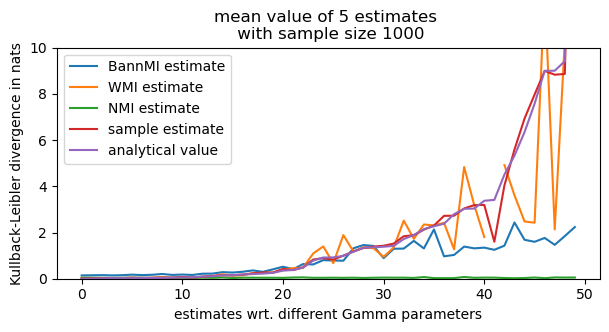

In [9]:
# make plot
fig, ax = plt.subplots(figsize=(7,3))
plt.plot(range(len(F)), F.BannMI, label='BannMI estimate')
plt.plot(range(len(F)), F.WMI, label='WMI estimate')
plt.plot(range(len(F)), F.NMI, label='NMI estimate')
plt.plot(range(len(F)), F.loc[:,['sample estimate']], label='sample estimate')
#plt.plot(range(len(F)), F.loc[:,['density estimate']], label='density estimate')
plt.plot(range(len(F)), F.truth, label='analytical value')
plt.xlabel('estimates wrt. different Gamma parameters')
plt.ylabel('Kullback-Leibler divergence in nats')
plt.title('mean value of ' + str(m) + ' estimates \n with sample size ' + str(n))
# restrict y-lim for better visualization
plt.ylim(0,10)
plt.legend()
plt.show()

#### correlation of estimators to analytical value:

In [10]:
# correlation to analytical values
print(F.iloc[:-5,:].corr().sort_values('truth', ascending=False).iloc[:,-1])

truth              1.000000
sample estimate    0.980426
WMI                0.849415
BannMI             0.843655
NMI               -0.182900
Name: truth, dtype: float64


## 0.3. Mutual information estimation

### 0.3.1 Gaussian

In [11]:
# Gaussian example with variable covariance matrix, sampled from Wishart distribution
#dimension
d = 5
# computations for estimator mean value
m = 5
# sample size
n = 1000

s = 0.5*np.ones(d**2).reshape(-1,d)
I = np.identity(d)
s = s + I

E=[]

for j in range(50):
    #make 2 Wisharts for pos.def. covariance matrices  
    S = wishart.rvs(df=10, scale = s, size = 1)
    S0 = S.copy()
    S0[1:,0]=0
    S0[0,1:]=0
    
    e = []
    #compute mean of 3 KLD estimators (see nnInfo for detailed information)
    for i in range(m):
        X = mv.rvs(np.ones(d), cov=S, size=n)
        x = X[:,0].copy()
        np.random.shuffle(x)
        Z = np.concatenate((x.reshape(-1,1),X[:,1:]), axis=1)
        
        e.append((nit.info('MI', unit='nats').estimator((X[:,0],X[:,1:])),
                  # Wang is not implemented in the class as MI estimator
                  est.WMI((X[:,0],X[:,1:]), measure='MI', k=4, unit='nats'), 
                  nit.info('MI', approach='nn_distance', unit='nats').estimator((X[:,0],X[:,1:])),
                  nit.KLD_gaussian((X,Z))))
        
    estimates = np.array(e).mean(axis=0)
    #compute true values based on parameter, parameter estimation and 
    #arithmetic mean estimate 
    truth = nit.KLD_gaussian(tpl=False, mu0=np.zeros(d), 
                             mu1=np.zeros(d), cov0=S, cov1=S0, samples=False)
    
    E.append(list(estimates) + [truth])
F = pd.DataFrame(E, columns=['BannMI', 'WMI', 'KSG', 'sample estimate','truth'])
F.sort_values(by='truth', inplace=True)
F.reset_index(drop=True, inplace=True)

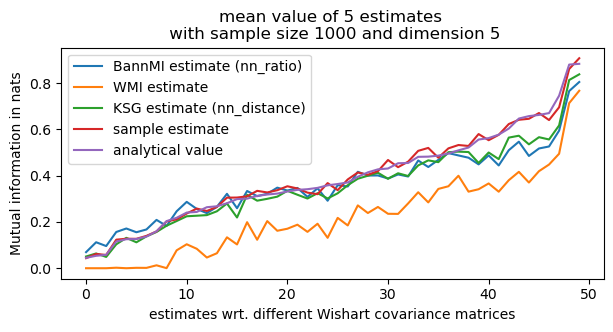

In [12]:
# make plot
fig, ax = plt.subplots(figsize=(7,3))
plt.plot(range(len(F)), F.BannMI, label='BannMI estimate (nn_ratio)')
plt.plot(range(len(F)), F.WMI, label='WMI estimate')
plt.plot(range(len(F)), F.KSG, label='KSG estimate (nn_distance)')
plt.plot(range(len(F)), F.loc[:,['sample estimate']], label='sample estimate')
#plt.plot(range(len(F)), F.loc[:,['density estimate']], label='density estimate')
plt.plot(range(len(F)), F.truth, label='analytical value')
plt.xlabel('estimates wrt. different Wishart covariance matrices')
plt.ylabel('Mutual information in nats')
plt.title('mean value of ' + str(m) + ' estimates \n with sample size ' + str(n) + ' and dimension ' + str(d))
#plt.ylim(0,10)
plt.legend()
plt.show()

#### correlation of estimators to analytical value:

In [13]:
# correlation to analytical value
print(F.iloc[:-5,:].corr().sort_values('truth', ascending=False).iloc[:,-1])

truth              1.000000
sample estimate    0.995741
KSG                0.985961
BannMI             0.971861
WMI                0.961564
Name: truth, dtype: float64


### 0.3.2. bivariate Exponential

In [14]:
#this file produces benchmark results for bivariate exponential as in the paper
# in some cases, although available on conda, pymc3 has to be installed via pip
print('prints 9 progress bars (for each dependency values D):')
# suppress pymc3 logger and only show progress bar
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)
logger.propagate = False


MIs = []
SDs = []
# dependeny parameter, number of computations for mean value (chains)
D = np.arange(0.1,1,step=0.1)
# number of chains
c = 5

#sample from bivariate distribution, as proposed by Gumble et al.
for delta in D:
    def logp(x,y,delta = delta):
        return np.log(1+(x+y-1)*delta + x*y*delta**2)-(x+y+x*y*delta)
         
    with pm.Model() as model:
        x = pm.Exponential('x', lam=1)
        y = pm.Exponential('y', lam=1)
        mv_exp = pm.DensityDist('mv_exp', logp, 
                                observed = dict(x=x, y=y))
        trace = pm.sample(tune=2000, draws=1000, chains=c,
                          return_inferencedata=True, target_accept=0.9, 
                          idata_kwargs={"density_dist_obs": False})
        
    
    # compute MI for all traces
    mis = []
    for i in range(c):
        y = (np.array(trace['posterior']['x'][i,:]).reshape(-1,1),
             np.array(trace['posterior']['y'][i,:]).reshape(-1,1))
        mis.append((nit.info('MI', approach='nn_distance', unit='nats').estimator(y),
                    nit.info('MI', unit='nats').estimator(y),
                    nit.info('MI', unit='nats', prior=1).estimator(y)))
    estimates = np.array(mis).mean(axis=0)
    estimates_sd = np.array(mis).std(axis=0)
    MIs.append(estimates)
    SDs.append(estimates_sd)

cols =  ['KSG', 'BannMI','uBannMI']   
MI = pd.DataFrame(MIs, columns=cols, index=D)
SD = pd.DataFrame(SDs, columns=cols, index=D)
#%%

prints 9 progress bars (for each dependency values D):


In [15]:
# numeric integration to compute MI for biariate exponential variable with componentwise dependency
truth = []
for delta in D:
    def fxy(x,y):
        return (1+(x+y-1)*delta + x*y*delta**2)*np.exp(-x-y-x*y*delta)
    
    def fxfy(x,y):
        return np.exp(-x-y)
    # KLD formula is shortened wrt. fxy/fxfy
    def KLD(x,y):
        return (np.log(1 + (x+y-1)*delta + x*y*delta**2) - delta*x*y)*fxy(x,y)
    
    # x-axis value until where integration takes place to ensure convergence
    m = 100
    result = nquad(KLD, [[0,m],[0,m]]) 
    truth.append(result[0])
# add numeric 'truth'    
MI['numeric estimate'] = truth

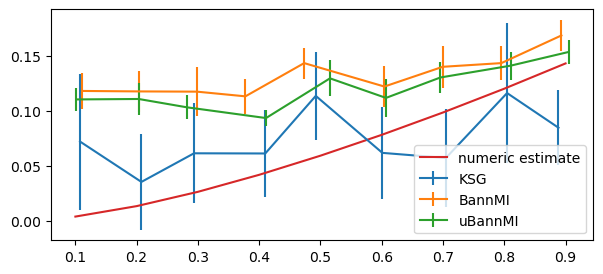

In [16]:
# make plot
fig, ax = plt.subplots(figsize=(7,3))
for i in range(3):
    ax.errorbar(np.random.normal(np.array(D),0.01),MI.iloc[:,i], SD.iloc[:,i], label=cols[i])
ax.plot(np.array(D),MI.iloc[:,-1], label='numeric estimate')
plt.legend()
plt.show()  

#### correlation of estimators to numerical value:

In [17]:
# correlation to numeric value
print(MI.corr().sort_values('numeric estimate', ascending=False).iloc[:,-1])

numeric estimate    1.000000
BannMI              0.856765
uBannMI             0.835859
KSG                 0.490655
Name: numeric estimate, dtype: float64


# 1. Motivational example for 2-to-1 dependency analysis

In [18]:
# example as in BannMI paper
cor = []
uncor = []
for i in range(50):
    # 2D uniform
    x = uniform.rvs(size = (5000,2)) 
    
    #evaluation pdfs of 2D gaussians on uniform sample 
    z = np.random.normal(mv([0,0],[[1,0.95],[0.95,1]]).pdf(x),0.01)
    z_star = np.random.normal(mv([0,0],[[1,0],[0,1]]).pdf(x),0.01)


    cor.append([nit.info('MI').estimator((x,z)),
                nit.info('MI').estimator((x[:,0],z)), 
                np.corrcoef((x[:,0],z))[0,1]])
                
    uncor.append([nit.info('MI').estimator((x,z_star)),
                  nit.info('MI').estimator((x[:,0],z_star)), 
                  np.corrcoef((x[:,0],z_star))[0,1]])


ind = ['joint MI', 'univ. MI', 'cor'] 
Cor = pd.DataFrame(cor, columns = ind)
Uncor = pd.DataFrame(uncor, columns = ind)

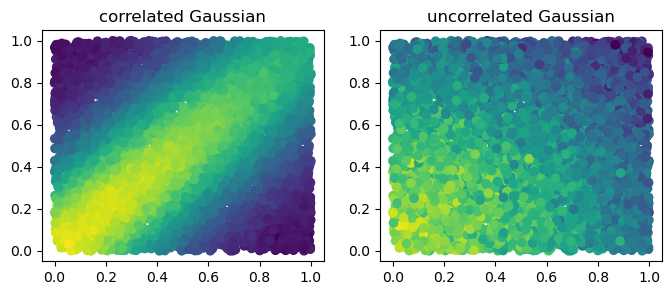

In [19]:
# make plot 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
ax2.scatter(x[:,0], x[:,1], c = z_star)
ax2.set_title('uncorrelated Gaussian')
ax1.scatter(x[:,0], x[:,1], c = z)
ax1.set_title('correlated Gaussian')
plt.show()

#### increased information about 'color'-variable in correlated setting can only be captures via joint MI

In [20]:
# show different measures to capture dependency between x- and y-axis and color scheme
C = pd.concat([Cor.mean(axis= 0), Uncor.mean(axis= 0)], axis = 1)
C.columns= ['correlated', 'uncorrelated']
print(C)

          correlated  uncorrelated
joint MI    3.046487      1.071425
univ. MI    0.625474      0.585206
cor        -0.163070     -0.633444


# 2. Application on cell lines: phosphoproteomics

In [21]:
# compute MI between kinases and an apoptotic marker to determine their potential role in apoptosis

# cell lines are adjusted to 0 as smallest value and reduced to EGF stimulation only
control = ['MCF12A', '184B5']
cancer =  ['HBL100', 'HCC3153']
lines = control + cancer


Lines=[]
t = []
m = 25


for n,i in enumerate(lines):
    x = pd.read_csv('data/' + i + '.csv')
    t = t + list(np.unique(x.time))
    Lines.append(x)

# efa as 'affector for apoptosis'
efas = ['p.SMAD23', 'p.AMPK', 'p.JNK', 'p.STAT1']
# indicator of apoptosis
marker = ['cleavedCas']

time = np.unique(t)

MI = []
for l in Lines:
    MI_mean = []
    MI_sd = []
    for t in time:
        X = l.loc[l.time==t,:]
        mis = []
        for j in range(m):
            x = X.sample(500, axis=0)
            mis.append(nit.info('MI').estimator((x.loc[:,marker], x.loc[:,efas])))

        MI_mean.append(np.mean(mis))  
        MI_sd.append(np.std(mis))  
    MI.append((MI_mean, MI_sd))

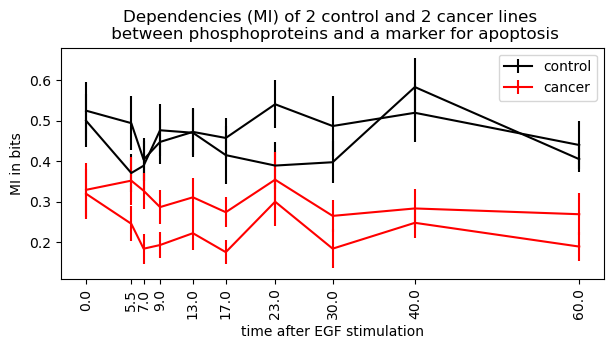

In [22]:
# plot MI for each line
fig, ax = plt.subplots(figsize=(7,3))
for j in range(4):
    if j == 0:
        ax.errorbar(time, MI[j][0], MI[j][1], color='black', label='control')
    if j == 1: 
        ax.errorbar(time, MI[j][0], MI[j][1], color='black')
    if j == 2: 
        ax.errorbar(time, MI[j][0], MI[j][1], color='red', label='cancer')
    if j == 3:    
        ax.errorbar(time, MI[j][0], MI[j][1], color='red')
ax.set_xticks(time)
ax.set_xticklabels(time, rotation=90)
ax.set_title('Dependencies (MI) of 2 control and 2 cancer lines \n between phosphoproteins and a marker for apoptosis')
ax.set_ylabel('MI in bits')
ax.set_xlabel('time after EGF stimulation')
plt.legend()    
plt.show()

#### References:
**KozLeo**: Kozachenko, L. and Leonenko, N. (1987). Sample Estimate of the Entropy
of a Random Vector. Problems of Information Transmission, 23(2),
95–101.

**WMI**: Wang, Q. et al. (2009). Divergence Estimation for Multidimensional
Densities Via k-Nearest-Neighbor Distances. IEEE Transactions of
Information Theory, 55(5), 2392–2405.

**NMI**: Noshad, M. et al. (2017). Direct estimation of information divergence
using nearest neighbor ratios. In 2017 IEEE International Symposium
on Information Theory (ISIT 2017)", pages 903 – 907, Aachen, Germany.
Institute of Electrical and Electronics Engineers ( IEEE ).

**KSG**: Kraskov, A. et al. (2004). Estimating mutual information. Phys. Rev. E,
69, 066138.

**(u)BannMI**: Schmidt, B. et al. BannMI Deciphers Potential n-to-1 Information
Transduction in Signalling Pathways to Unravel
Message of Intrinsic Apoptosis

cell lines used in **2. Application on cell lines** are contributed by Attila Gabor and Marco Tognetti. They were obtained as part of the Single Cell Signaling in Breast Cancer Challenge through Synapse ID syn20564742

**bivariate exponential distribution** was proposed by: Gumbel, E. J. (1960). Bivariate exponential distributions. Journal of the American Statistical Association, 55(292), 698–707.